# Relative Elevation Model Visualisation

- Author: [Jenna Guffogg](https://github.com/ylaya)
- Based on ["Relative Elevation Model Visualisation"](https://github.com/DahnJ/REM-xarray/blob/master/rem-in-xarray-tutorial.ipynb) by [Dahn](https://github.com/DahnJ)

This tutorial explores importing and pre-processing digital elevation data (DEM) and then using this data to create a relative elevation model (REM).

An REM uses the river's elevation to normalise the model, so that **height relative to the river is shown, rather than height above sea level**. This makes subtle changes in elevation around the river (or other waterbody of choice) more visible. It also looks hella pretty in pictures!

#### Part 1:

Before creating the REM, a geotif containing elevation data is imported, and some exploratory visualisations are used to better understand the dataset.

#### Part 2:

Using feature data from OSM and the DEM data, generate the REM for the area of interest (a section of the Yarra River, Victoria, Australia).

**Data sources:**
- [Victoria Elevation DEM 10m](https://discover.data.vic.gov.au/dataset/vicmap-elevation-dem-10m) data downloaded through the [ELVIS portal](https://elevation.fsdf.org.au/)
- [Yarra River feature data](https://www.openstreetmap.org/relation/2211681) imported with the OSMnX package


## Import packages

In [1]:
import numpy as np
import xarray as xr
import shapely
import rioxarray
import xrspatial
import osmnx as ox # Downloading data from OSM
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation
import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack

## Define the path to a lidar derived digital elevation model (DEM)

The example DEM in this notebook was downloaded previously, so a relative path is shown. Change his path to the location of your DEM geotiff.

The crs for the project is also set here. If your geotiff is not alreayy in WGS84, this can be used to reproject the data so it is in the same projection as the OSM feature data.

In [2]:
crs = "EPSG:4326"
dem_path = 'data/input/DATA_785843/VIC Government/DEM/10 Metre/vmelev_dem10m.tif'

Load the DEM data using rioxarray. When you load raster data using rioxarray it is loaded as an xarray.DataArray. The DataArray object should contain:

- A numpy array of the pixel values
- Metadata like CRS, spatial extent
- other metadata

You can use rioxarray to interrogate the data once loaded, as shown below.

In [3]:
dem = rioxarray.open_rasterio(dem_path)
dem

<xarray.DataArray (band: 1, y: 557, x: 860)> Size: 2MB
[479020 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 145.2 145.2 145.2 145.2 ... 145.3 145.3 145.3
  * y            (y) float64 4kB -37.67 -37.67 -37.67 ... -37.72 -37.72 -37.72
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      elevation

In [4]:
print("The CRS for this data is:", dem.rio.crs)
print("The spatial extent is:", dem.rio.bounds())
print("The no data value is:", dem.rio.nodata)

The CRS for this data is: EPSG:4326
The spatial extent is: (145.24588045295687, -37.7229438139799, 145.34340300647605, -37.672755544284435)
The no data value is: -3.4028235e+38


The DEM should represent terrain model data but when plotted the range of values is not what is expected.

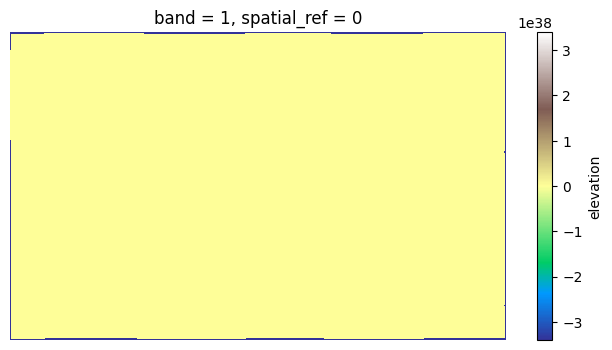

In [5]:
f, ax = plt.subplots(figsize=(8, 4))
dem.plot(cmap="terrain",
                 ax=ax)
ax.set_axis_off()
plt.show()

By plotting a histogram of the pixel values, you can check for outlier values that need to be addressed. You can see there are pixel values in the negative range.

When we look at the min and max values, the min value returns a negative value that is the same as the nodata value from above. These values are skewing the plot colours for the DEM.

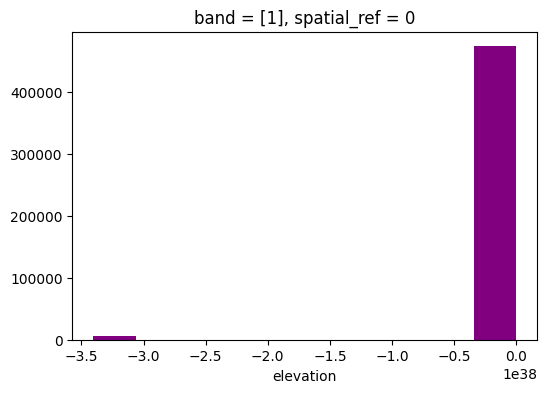

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
dem.plot.hist(ax=ax, color="purple")
plt.show()

In [7]:
print("the minimum raster value is: ", np.nanmin(dem.values))
print("the maximum raster value is: ", np.nanmax(dem.values))

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  269.3495


You can try reading the data with a mask to address the outlier values. If the outliers are nodata values, this should resolve the plotting issue.

Looking at the DataArray, there is an additional dimension called "band". The extra dimension could get in the way of processing so we'll remove it.

In [8]:
print(dem.shape)
dem = rioxarray.open_rasterio(dem_path, masked=True).squeeze()
print(dem.shape)

(1, 557, 860)
(557, 860)


Plotting the DEM again, and investigating the histogram, confirms that the data values are now what we expected:

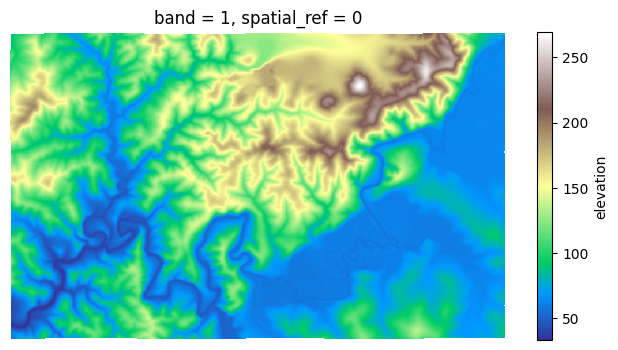

In [9]:
f, ax = plt.subplots(figsize=(8, 4))
dem.plot(cmap="terrain",
                 ax=ax)
ax.set_axis_off()
plt.show()

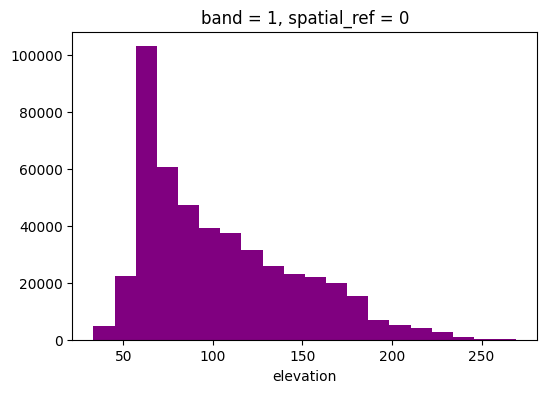

In [10]:
f, ax = plt.subplots(figsize=(6, 4))
dem.plot.hist(color="purple",
                      bins=20)
plt.show()

## Get feature data for the River

To get the vector data for the section of the river that inversects our DEM, we will:

- set a string query for the location
- use OSMnX to query open source [OpenStreetMap](https://www.openstreetmap.org/) data
- reproject the OSM data to the same CRS as the DEM
- check that the query returned valid geometry using an if/else statement.

You can also use the Way ID of the river or waterbody instead of doing a name search.
For the Yarra River, its ID is [2211681](https://www.openstreetmap.org/relation/2211681)

Both options are shown.

##### Get the feature data for the Yarra River using a place query based on name

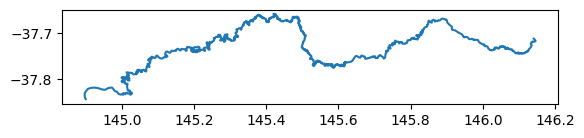

In [11]:
place_query = "Yarra River, Victoria, Australia"

waterbody = ox.geocode_to_gdf(place_query, which_result=1)
waterbody_geom = waterbody.geometry

if not waterbody.empty:
    waterbody = waterbody.to_crs(dem.rio.crs)
    waterbody.plot()
    plt.show()
else:
    print("No data found for the specified location.")

##### Get the feature data for the Yarra River using a place query based on ID

This cell is commented out as only one query is needed and I chose to use the name-based query.

In [12]:
# id_query = "2211681"

# waterbody = ox.geocode_to_gdf(id_query, by_osmid=True)
# waterbody_geom = waterbody.geometry

# if not waterbody.empty:
#     waterbody = waterbody.to_crs(dem.rio.crs)
#     waterbody.plot()
#     plt.show()
# else:
#     print("No data found for the specified location.")

## Clip waterbody to area of interest

The OSMnX query returned the data for the entire Yarra River - now we clip the returned feature so we have a geodataframe containing the section of river that intersects with the area of the DEM.

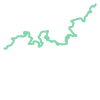

In [13]:
dem.rio.bounds()

bounds = dem.rio.bounds()
xmin, ymin, xmax, ymax = bounds

waterbody = waterbody.clip(bounds)
waterbody_geom = waterbody.geometry.iloc[0]
waterbody_geom

check that everything looks the way we expect - waterbody polygon and surrounding elevation - by plotting them together

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

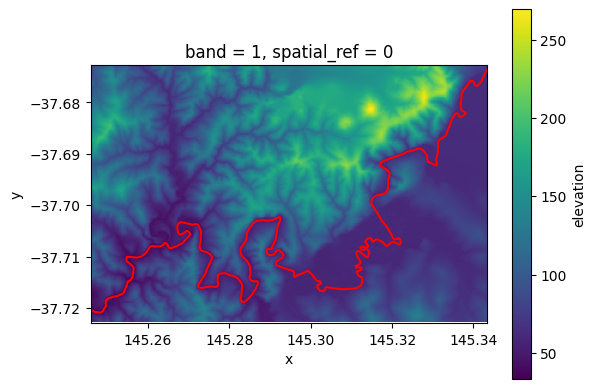

In [14]:
fig, ax = plt.subplots()
dem.squeeze().plot.imshow(ax=ax)
waterbody.plot(ax=ax, color='red')

## Calculte the REM

To calculate the REM, we need to

- Sample the elevation along the river
- Interpolate the sampled elevation values to create a 2D elevation raster
- Subtract the interpolated elevation raster from the DEM

Function for getting the coordinates for an input geometry and returning them as two DataArrays

In [15]:
def split_coords_to_array(geom):
    x = []
    y = []
    for i in shapely.get_coordinates(geom):
        x.append(i[0])
        y.append(i[1])
    xs, ys = xr.DataArray(x, dims='z'), xr.DataArray(y, dims='z')
    return xs, ys

Use the function to get two DataArrays - one containing the longitude (x) values, and the other containing latitude (y).

You can check the variable `xs` to see that it is now an array containing only longitude values.

In [16]:
xs, ys = split_coords_to_array(waterbody_geom)
xs

<xarray.DataArray (z: 419)> Size: 3kB
array([145.34340301, 145.3431586 , 145.342629  , 145.3420942 ,
       145.3412359 , 145.3408668 , 145.3404978 , 145.3399484 ,
       145.3396051 , 145.339236  , 145.3374079 , 145.3370817 ,
       145.3370044 , 145.3368242 , 145.3369272 , 145.3371933 ,
       145.3380773 , 145.3380773 , 145.3371246 , 145.3367298 ,
       145.3364036 , 145.3361805 , 145.3358887 , 145.335511  ,
       145.3347214 , 145.3339832 , 145.3335626 , 145.3333824 ,
       145.3331249 , 145.3316915 , 145.3314426 , 145.3313482 ,
       145.3313053 , 145.3312538 , 145.3308239 , 145.3310392 ,
       145.3308676 , 145.3305156 , 145.3299148 , 145.3288763 ,
       145.3286789 , 145.3286016 , 145.328387  , 145.3274343 ,
       145.3268936 , 145.3265245 , 145.3247221 , 145.3237436 ,
       145.3226021 , 145.3181131 , 145.3173149 , 145.3170746 ,
       145.3170746 , 145.3173321 , 145.3189113 , 145.3192461 ,
       145.3194006 , 145.3190401 , 145.3189886 , 145.3186453 ,
       145.3182161 , 145.3174093 , 145.3159502 , 145.3152378 ,
       145.3149202 , 145.3149202 , 145.317538  , 145.3185852 ,
       145.3198726 , 145.3201645 , 145.3205765 , 145.3210485 ,
       145.3214863 , 145.3217781 , 145.3220356 , 145.32213   ,
       145.3220957 , 145.3218982 , 145.3215721 , 145.3212974 ,
...
       145.2756428 , 145.2749733 , 145.273291  , 145.2726044 ,
       145.2723125 , 145.2723812 , 145.2741407 , 145.2743553 ,
       145.2757114 , 145.2757801 , 145.2752909 , 145.2746471 ,
       145.2731022 , 145.2726988 , 145.2726816 , 145.2729048 ,
       145.2729563 , 145.2728962 , 145.2730764 , 145.272304  ,
       145.2718853 , 145.2717557 , 145.2716345 , 145.271171  ,
       145.2709072 , 145.2692391 , 145.2689268 , 145.2679695 ,
       145.2675146 , 145.2672571 , 145.267197  , 145.267403  ,
       145.2676004 , 145.267918  , 145.2687162 , 145.269463  ,
       145.269832  , 145.2704071 , 145.2702354 , 145.268433  ,
       145.2669653 , 145.2655405 , 145.265259  , 145.26518   ,
       145.2647772 , 145.2644333 , 145.264107  , 145.2638411 ,
       145.2629999 , 145.2612661 , 145.2609063 , 145.2604779 ,
       145.2600731 , 145.2595667 , 145.2590946 , 145.2583136 ,
       145.2572922 , 145.2549318 , 145.2547602 , 145.2546743 ,
       145.2557386 , 145.2563309 , 145.2565025 , 145.2562021 ,
       145.2557987 , 145.2550863 , 145.2547344 , 145.2539104 ,
       145.2531637 , 145.252314  , 145.2512497 , 145.2505287 ,
       145.2498249 , 145.2496103 , 145.2496618 , 145.2487778 ,
       145.2482885 , 145.2468552 , 145.24588045])
Dimensions without coordinates: z

The `interp()` function from xarray gets the elevation data for the river by interpolating the DEM at the coordinates defined in `xs` and `ys`. 

The interpolation method `nearest` means that for each river point, the elevation value is taken from the nearest point in the DEM grid.

In [17]:
sampled = dem.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

## Interpolate

- Sampled River Coordinates: The code extracts coordinates (x, y) for sampled points along the river. These coordinates are stored in a NumPy array where each row represents a point in 2D space (c_sampled).
- DEM Coordinates: It also retrieves the coordinates for each point in the DEM, which covers the broader area around the river. These coordinates are structured into a grid (c_interpolate) representing every possible (x, y) position on the DEM.
- Sampled Values: The elevation values at the sampled river points are extracted and flattened into a one-dimensional array (values).

In [18]:
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T


c_x, c_y = [dem.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# sampled values
values = sampled.values.ravel()

c_interpolate

array([[145.24593715, -37.6728006 ],
       [145.24605055, -37.6728006 ],
       [145.24616395, -37.6728006 ],
       ...,
       [145.34311951, -37.72289876],
       [145.34323291, -37.72289876],
       [145.34334631, -37.72289876]])

### Inverse Distance Weighted (IDW):

IDW calculates the values of unknown locations by assigning weights based on the distance between the unknown point and its neighbouring data points. It is a simple and fast method of interpolation, but can be overly sensitive to outliers and may have a smoothing effect on your data.

- Setup KDTree for Searching: 
     - A KDTree is built using the sampled river coordinates. This helps for quick nearest-neighbor searches
- Identify Nearest Neighbors: 
     - set `k` to the number of points to include
     - For each point in the DEM (c_interpolate), the KDTree identifies the `k` nearest points that elevation data is available for
     - returns the index (actual elevation value) and distance from target location
- Calculate Weights: 
     - The influence of each neighboring point on the estimated elevation is inversely proportional to its distance from the target location; nearer points have a greater impact than farther ones.
- Compute Interpolated Values

In [19]:
#perform the interpolation
tree = KDTree(c_sampled)

distances, indices = tree.query(c_interpolate, k=5)

weights = 1/distances
weights = weights / weights.sum(axis=1).reshape(-1,1)

interpolated_values = (weights * values[indices]).sum(axis=1)

make data array from interpolated values

In [20]:
elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

Plot the interpolated values to check them

<Axes: xlabel='x', ylabel='y'>

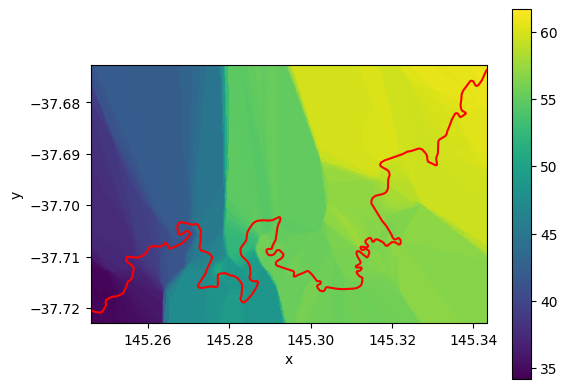

In [21]:
fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)
waterbody.plot(ax=ax, color='red')

## Use the original DEM and the interpolated data to create the REM

In [22]:
rem = dem - elevation_raster
rem

<xarray.DataArray (y: 557, x: 860)> Size: 4MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ..., 13.43859403,
                nan,         nan],
       ...,
       [        nan, 19.35130398, 20.32561125, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 7kB 145.2 145.2 145.2 145.2 ... 145.3 145.3 145.3
  * y            (y) float64 4kB -37.67 -37.67 -37.67 ... -37.72 -37.72 -37.72
    spatial_ref  int64 8B 0

## Visualisation
The final DataFrames need to be 'flipped' vertically to return them to the correct orientation, otherwise the final output images will be inverted compared to the original input DEM data. Once flipped, the final images can be produced.

In [23]:
rem_flipped = xr.DataArray(np.flipud(rem.values), dims=rem.dims, coords=rem.coords)

dem_flipped = xr.DataArray(np.flipud(dem.values), dims=dem.dims, coords=dem.coords)

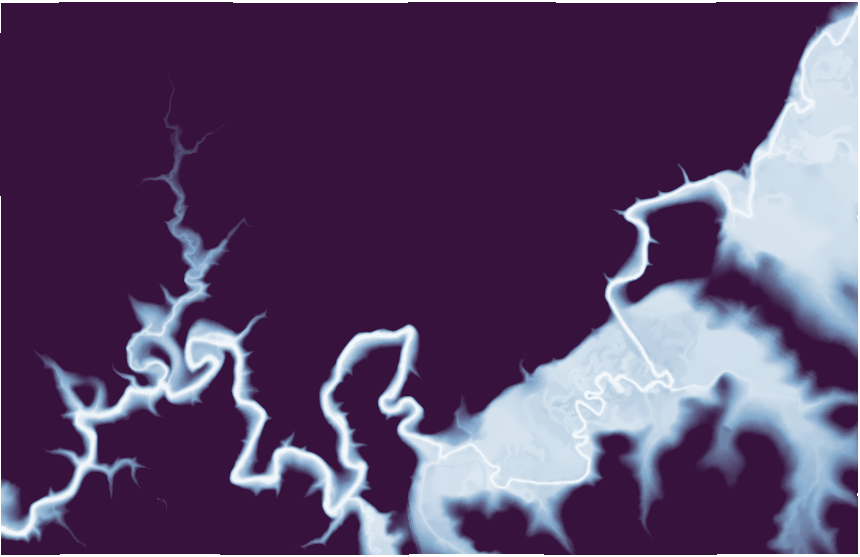

In [24]:
colors = ['#f2f7fb', '#81a8cb', '#37123d']

shade(rem_flipped.squeeze(), cmap=colors, span=[0, 20], how='linear')

Stack the DEM and the REM and visualise

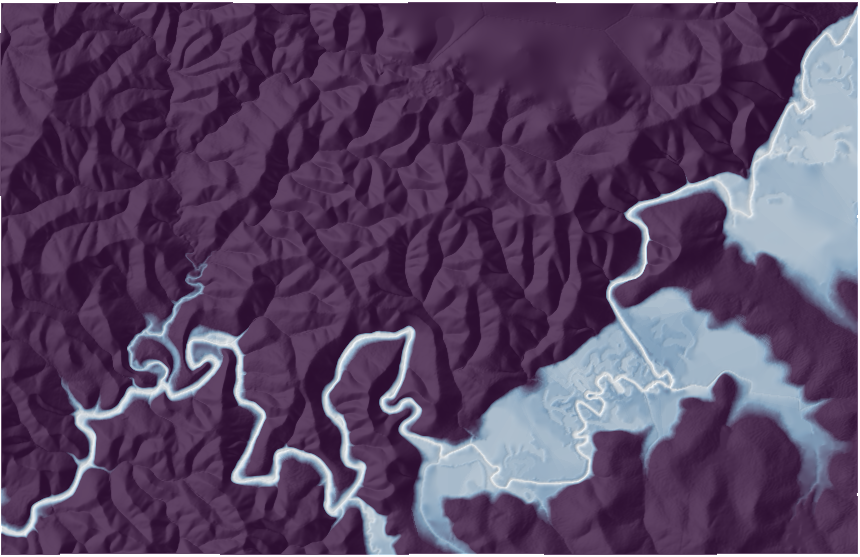

In [25]:
a = shade(xrspatial.hillshade(dem_flipped.squeeze(), angle_altitude=1, azimuth=250), cmap=['black', 'white'], how='linear')
b = shade(rem_flipped.squeeze(), cmap=colors, span=[0, 10], how='linear', alpha=200)
stack(a, b)